In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_BN(conv_num=1):
    init_channel = 64
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/4))), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7386 - acc: 0.1912
Epoch 00001: val_loss improved from inf to 1.97164, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_BN_6_conv_checkpoint/001-1.9716.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 2.7385 - acc: 0.1913 - val_loss: 1.9716 - val_acc: 0.3864
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8310 - acc: 0.4101
Epoch 00002: val_loss improved from 1.97164 to 1.37260, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_BN_6_conv_checkpoint/002-1.3726.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 1.8309 - acc: 0.4102 - val_loss: 1.3726 - val_acc: 0.5528
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4848 - acc: 0.5197
Epoch 00003: val_loss improved from 1.37260 to 1.10338, savin

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5384 - acc: 0.8401
Epoch 00024: val_loss improved from 0.54335 to 0.52155, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_BN_6_conv_checkpoint/024-0.5215.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.5385 - acc: 0.8400 - val_loss: 0.5215 - val_acc: 0.8563
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5274 - acc: 0.8417
Epoch 00025: val_loss did not improve from 0.52155
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.5274 - acc: 0.8417 - val_loss: 0.5455 - val_acc: 0.8512
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5145 - acc: 0.8457
Epoch 00026: val_loss did not improve from 0.52155
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.5145 - acc: 0.8456 - val_loss: 0.5903 - val_acc: 0.8446
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3520 - acc: 0.8923
Epoch 00052: val_loss improved from 0.42104 to 0.40578, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_BN_6_conv_checkpoint/052-0.4058.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.3520 - acc: 0.8924 - val_loss: 0.4058 - val_acc: 0.8887
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3444 - acc: 0.8936
Epoch 00053: val_loss did not improve from 0.40578
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.3444 - acc: 0.8937 - val_loss: 0.4862 - val_acc: 0.8644
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3409 - acc: 0.8961
Epoch 00054: val_loss did not improve from 0.40578
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.3411 - acc: 0.8960 - val_loss: 1.0149 - val_acc: 0.7365
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2632 - acc: 0.9177
Epoch 00081: val_loss did not improve from 0.39719
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2632 - acc: 0.9177 - val_loss: 0.4984 - val_acc: 0.8619
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2563 - acc: 0.9181
Epoch 00082: val_loss did not improve from 0.39719
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2563 - acc: 0.9181 - val_loss: 0.4749 - val_acc: 0.8696
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2529 - acc: 0.9193
Epoch 00083: val_loss improved from 0.39719 to 0.39587, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_BN_6_conv_checkpoint/083-0.3959.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2529 - acc: 0.9193 - val_loss: 0.3959 - val_acc: 0.8915
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2009 - acc: 0.9342
Epoch 00110: val_loss did not improve from 0.38154
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2009 - acc: 0.9342 - val_loss: 0.4632 - val_acc: 0.8772
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2055 - acc: 0.9344
Epoch 00111: val_loss did not improve from 0.38154
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2055 - acc: 0.9344 - val_loss: 0.6437 - val_acc: 0.8411
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2020 - acc: 0.9346
Epoch 00112: val_loss did not improve from 0.38154
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2020 - acc: 0.9347 - val_loss: 0.4289 - val_acc: 0.8891
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2000 - acc: 0.9347
Epoch 00113: val_loss did not improve from 0.38154
36805/36805 [=======

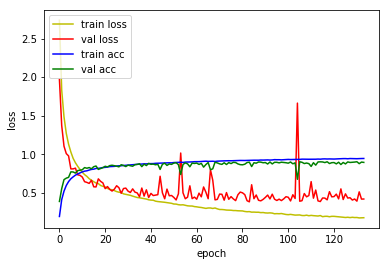

4815/4815 [==============================] - 4s 865us/sample - loss: 0.4655 - acc: 0.8667
Loss: 0.46554678135076666 Accuracy: 0.8666667

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.9206 - acc: 0.1387
Epoch 00001: val_loss improved from inf to 2.27517, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_BN_7_conv_checkpoint/001-2.2752.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 2.9205 - acc: 0.1387 - val_loss: 2.2752 - val_acc: 0.3317
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1226 - acc: 0.3149
Epoch 00002: val_loss improved from 2.27517 to 1.58382, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_BN_7_conv_checkpoint/002-1.5838.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 2.1226 - acc: 0.3149 - val_loss: 1.5838 - val_acc: 0.5344
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4786 - acc: 0.8575
Epoch 00024: val_loss improved from 0.40282 to 0.38643, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_BN_7_conv_checkpoint/024-0.3864.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.4785 - acc: 0.8575 - val_loss: 0.3864 - val_acc: 0.8977
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4640 - acc: 0.8616
Epoch 00025: val_loss improved from 0.38643 to 0.38199, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_BN_7_conv_checkpoint/025-0.3820.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.4642 - acc: 0.8615 - val_loss: 0.3820 - val_acc: 0.8938
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4518 - acc: 0.8667
Epoch 00026: val_loss did not improve from 0.38199
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.4519 - acc: 0.8666 - val_los

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2970 - acc: 0.9091
Epoch 00050: val_loss did not improve from 0.29809
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2971 - acc: 0.9091 - val_loss: 0.3139 - val_acc: 0.9140
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3012 - acc: 0.9055
Epoch 00051: val_loss did not improve from 0.29809
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.3013 - acc: 0.9054 - val_loss: 0.3534 - val_acc: 0.9029
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2920 - acc: 0.9107
Epoch 00052: val_loss improved from 0.29809 to 0.29492, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_BN_7_conv_checkpoint/052-0.2949.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2920 - acc: 0.9107 - val_loss: 0.2949 - val_acc: 0.9201
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2160 - acc: 0.9324
Epoch 00078: val_loss improved from 0.27257 to 0.26968, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_BN_7_conv_checkpoint/078-0.2697.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2161 - acc: 0.9324 - val_loss: 0.2697 - val_acc: 0.9259
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2175 - acc: 0.9325
Epoch 00079: val_loss did not improve from 0.26968
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2174 - acc: 0.9325 - val_loss: 0.2881 - val_acc: 0.9222
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2142 - acc: 0.9327
Epoch 00080: val_loss improved from 0.26968 to 0.26044, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_BN_7_conv_checkpoint/080-0.2604.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2145 - acc: 0.9326 - val_los

Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1685 - acc: 0.9466
Epoch 00107: val_loss did not improve from 0.26044
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1690 - acc: 0.9465 - val_loss: 0.2761 - val_acc: 0.9234
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1713 - acc: 0.9447
Epoch 00108: val_loss did not improve from 0.26044
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1713 - acc: 0.9447 - val_loss: 0.2786 - val_acc: 0.9308
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1639 - acc: 0.9471
Epoch 00109: val_loss did not improve from 0.26044
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1639 - acc: 0.9471 - val_loss: 0.3168 - val_acc: 0.9201
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1594 - acc: 0.9484
Epoch 00110: val_loss did not improve from 0.26044
36805/36805 [=======

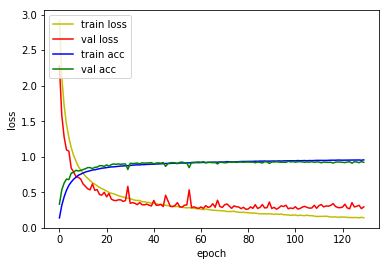

4815/4815 [==============================] - 4s 904us/sample - loss: 0.3087 - acc: 0.9121
Loss: 0.30870168163273815 Accuracy: 0.91214955

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0485 - acc: 0.1330
Epoch 00001: val_loss improved from inf to 2.46367, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_BN_8_conv_checkpoint/001-2.4637.hdf5
36805/36805 [==============================] - 97s 3ms/sample - loss: 3.0485 - acc: 0.1330 - val_loss: 2.4637 - val_acc: 0.2548
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3388 - acc: 0.2569
Epoch 00002: val_loss improved from 2.46367 to 1.78156, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_BN_8_conv_checkpoint/002-1.7816.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.3390 - acc: 0.2569 - val_loss: 1.7816 - val_acc: 0.4847
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3971 - acc: 0.8806
Epoch 00024: val_loss did not improve from 0.28966
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.3971 - acc: 0.8806 - val_loss: 0.2937 - val_acc: 0.9196
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3960 - acc: 0.8810
Epoch 00025: val_loss did not improve from 0.28966
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.3960 - acc: 0.8810 - val_loss: 0.2993 - val_acc: 0.9168
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3827 - acc: 0.8851
Epoch 00026: val_loss improved from 0.28966 to 0.28120, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_BN_8_conv_checkpoint/026-0.2812.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.3827 - acc: 0.8850 - val_loss: 0.2812 - val_acc: 0.9196
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - lo

36800/36805 [============================>.] - ETA: 0s - loss: 0.2311 - acc: 0.9292
Epoch 00050: val_loss did not improve from 0.19935
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2311 - acc: 0.9292 - val_loss: 0.2331 - val_acc: 0.9362
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2294 - acc: 0.9285
Epoch 00051: val_loss did not improve from 0.19935
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2294 - acc: 0.9284 - val_loss: 0.2096 - val_acc: 0.9453
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2295 - acc: 0.9282
Epoch 00052: val_loss did not improve from 0.19935
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2295 - acc: 0.9282 - val_loss: 0.2048 - val_acc: 0.9448
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2229 - acc: 0.9306
Epoch 00053: val_loss did not improve from 0.19935
36805/36805 [========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1579 - acc: 0.9497
Epoch 00079: val_loss did not improve from 0.19070
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1580 - acc: 0.9497 - val_loss: 0.2200 - val_acc: 0.9448
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1622 - acc: 0.9480
Epoch 00080: val_loss did not improve from 0.19070
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1622 - acc: 0.9480 - val_loss: 0.2356 - val_acc: 0.9376
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1485 - acc: 0.9536
Epoch 00081: val_loss did not improve from 0.19070
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1485 - acc: 0.9535 - val_loss: 0.1918 - val_acc: 0.9469
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1536 - acc: 0.9507
Epoch 00082: val_loss did not improve from 0.19070
36805/36805 [========================

Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1206 - acc: 0.9620
Epoch 00109: val_loss did not improve from 0.19070
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1206 - acc: 0.9620 - val_loss: 0.2487 - val_acc: 0.9413
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1145 - acc: 0.9635
Epoch 00110: val_loss did not improve from 0.19070
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1145 - acc: 0.9635 - val_loss: 0.2291 - val_acc: 0.9434
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1154 - acc: 0.9625
Epoch 00111: val_loss did not improve from 0.19070
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1155 - acc: 0.9625 - val_loss: 0.2189 - val_acc: 0.9474
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1120 - acc: 0.9639
Epoch 00112: val_loss did not improve from 0.19070
36805/36805 [=======

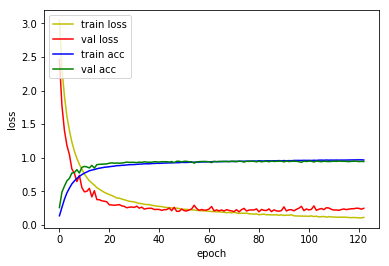

4815/4815 [==============================] - 4s 911us/sample - loss: 0.2263 - acc: 0.9321
Loss: 0.22633448646385473 Accuracy: 0.93208724

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0723 - acc: 0.1164
Epoch 00001: val_loss improved from inf to 2.44039, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_BN_9_conv_checkpoint/001-2.4404.hdf5
36805/36805 [==============================] - 100s 3ms/sample - loss: 3.0721 - acc: 0.1165 - val_loss: 2.4404 - val_acc: 0.2527
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3981 - acc: 0.2462
Epoch 00002: val_loss improved from 2.44039 to 1.82731, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_BN_9_conv_checkpoint/002-1.8273.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.3980 - acc: 0.2462 - val_loss: 1.8273 - val_acc: 0.4938
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6560 - acc: 0.7911
Epoch 00023: val_loss did not improve from 0.32394
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.6560 - acc: 0.7910 - val_loss: 0.3374 - val_acc: 0.9122
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6378 - acc: 0.7942
Epoch 00024: val_loss improved from 0.32394 to 0.31538, saving model to model/checkpoint/1D_CNN_custom_2_ch_64_DO_BN_9_conv_checkpoint/024-0.3154.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.6379 - acc: 0.7942 - val_loss: 0.3154 - val_acc: 0.9203
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6316 - acc: 0.7993
Epoch 00025: val_loss did not improve from 0.31538
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.6316 - acc: 0.7993 - val_loss: 0.3198 - val_acc: 0.9199
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - lo

36800/36805 [============================>.] - ETA: 0s - loss: 0.4118 - acc: 0.8662
Epoch 00049: val_loss did not improve from 0.19367
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.4118 - acc: 0.8662 - val_loss: 0.2119 - val_acc: 0.9425
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4049 - acc: 0.8702
Epoch 00050: val_loss did not improve from 0.19367
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.4051 - acc: 0.8702 - val_loss: 0.2008 - val_acc: 0.9481
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4015 - acc: 0.8711
Epoch 00051: val_loss did not improve from 0.19367
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.4018 - acc: 0.8710 - val_loss: 0.2311 - val_acc: 0.9359
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3966 - acc: 0.8707
Epoch 00052: val_loss did not improve from 0.19367
36805/36805 [========================

Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3096 - acc: 0.8973
Epoch 00078: val_loss did not improve from 0.18274
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.3096 - acc: 0.8973 - val_loss: 0.1954 - val_acc: 0.9453
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2915 - acc: 0.9047
Epoch 00079: val_loss did not improve from 0.18274
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2915 - acc: 0.9047 - val_loss: 0.1951 - val_acc: 0.9450
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2904 - acc: 0.9041
Epoch 00080: val_loss did not improve from 0.18274
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2904 - acc: 0.9041 - val_loss: 0.2046 - val_acc: 0.9453
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2925 - acc: 0.9043
Epoch 00081: val_loss did not improve from 0.18274
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.2421 - acc: 0.9187
Epoch 00107: val_loss did not improve from 0.18218
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2421 - acc: 0.9187 - val_loss: 0.2066 - val_acc: 0.9448
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2360 - acc: 0.9214
Epoch 00108: val_loss did not improve from 0.18218
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2362 - acc: 0.9213 - val_loss: 0.2061 - val_acc: 0.9483
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2424 - acc: 0.9182
Epoch 00109: val_loss did not improve from 0.18218
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2426 - acc: 0.9182 - val_loss: 0.1977 - val_acc: 0.9485
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2448 - acc: 0.9186
Epoch 00110: val_loss did not improve from 0.18218
36805/36805 [=====================

Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2035 - acc: 0.9305
Epoch 00137: val_loss did not improve from 0.18218
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2035 - acc: 0.9305 - val_loss: 0.1900 - val_acc: 0.9481
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1972 - acc: 0.9320
Epoch 00138: val_loss did not improve from 0.18218
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1979 - acc: 0.9319 - val_loss: 0.2242 - val_acc: 0.9453
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2170 - acc: 0.9280
Epoch 00139: val_loss did not improve from 0.18218
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2170 - acc: 0.9280 - val_loss: 0.1980 - val_acc: 0.9488
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2060 - acc: 0.9297
Epoch 00140: val_loss did not improve from 0.18218
36805/36805 [=======

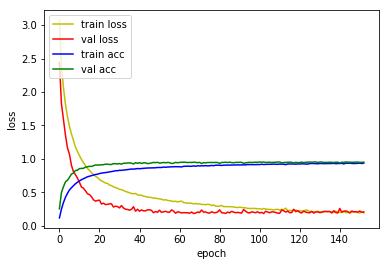

4815/4815 [==============================] - 5s 954us/sample - loss: 0.2525 - acc: 0.9327
Loss: 0.252502061780987 Accuracy: 0.9327103



In [10]:
for i in range(6, 10):
    base = '1D_CNN_custom_2_ch_64_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_2_ch_64_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(6, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_ch_64_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_46 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None

4815/4815 [==============================] - 5s 968us/sample - loss: 0.3087 - acc: 0.9121
Loss: 0.30870168163273815 Accuracy: 0.91214955

1D_CNN_custom_2_ch_64_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_58 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_58 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_59 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_59 (Activation)   

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2525 - acc: 0.9327
Loss: 0.252502061780987 Accuracy: 0.9327103


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(6, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_ch_64_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_46 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3502 - acc: 0.9057
Loss: 0.35020613295266934 Accuracy: 0.9057113

1D_CNN_custom_2_ch_64_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_58 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_58 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_59 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_59 (Activation)   (No

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2914 - acc: 0.9281
Loss: 0.29137914297736695 Accuracy: 0.92814124
